In [1]:
import tensorflow as tf
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.contrib.layers import fully_connected

# Model - 1d Resnet

 I build the model using resnet convolutional network. It is the 2-d convolutional neural network introduced in the reset paper but I fine-tune the model to be adjusted at 1-dimensional data set.

#### - Define function to recall

In [2]:
def weight_variable(shape, name):
    return tf.get_variable(name, shape=shape, dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape, name):
    return tf.get_variable(name, dtype=tf.float32, initializer=tf.truncated_normal(shape))

def conv1d(x, filters, kernel_size, name, stride=1, activation=tf.nn.relu, padding='SAME'):
    return tf.layers.conv1d(x, filters, kernel_size, strides=stride, use_bias=True, padding='SAME',name=name) 

def maxpool1d(x, pool_size, strides, name, padding='SAME'):
    return tf.layers.max_pooling1d(x, pool_size, strides, padding='SAME', name=name)

def resblock(x, filters, kernel_size, name):
    resblock=conv1d(x, filters, kernel_size, stride=1, name=name+'_conv1')
    resblock=tf.layers.batch_normalization(resblock, name=name+'_batch1')
    resblock=tf.nn.relu(resblock, name=name+'_relu')
    resblock=conv1d(resblock, filters, kernel_size, stride=1, name=name+'_conv2')
    resblock=tf.layers.batch_normalization(resblock, name=name+'_batch2')
    return tf.nn.relu(resblock+x)

def fullylayer(x, units, name):
    return tf.layers.dense(x, units, activation=tf.nn.elu, name=name)

def conv2ser(x, params_fc):
    return tf.reshape(x, [-1, params_fc.get_shape().as_list()[0]])

def resblock_s(x, filters, kernel_size, name):
    resblock=conv1d(x, filters, kernel_size, stride=2, name=name+'_conv1')
    shorcut=tf.layers.batch_normalization(resblock, name=name+'_batch1')
    resblock=tf.nn.relu(shorcut, name=name+'_relu')
    resblock=conv1d(resblock, filters, kernel_size, stride=1, name=name+'_conv2')
    resblock=tf.layers.batch_normalization(resblock, name=name+'_batch2')
    return tf.nn.relu(resblock+shorcut)    

### - ResentModel
    - Input size = (1, 74484) #input in tf.nn.conv1d - (batch, in-width, channels)
    - the number of layers = 33 convolutional layers + 2 fully connected layers + 1 softmax layers
    - Each layer's Activation function = relu activation
    - Each resnet block contains batch normalization layer

In [3]:
class BaseModel:
    def __init__(self, num_class):
        raise NotImplementedError
        
    def run(self, X, is_training):
        raise NotImplementedError

class Resnet1D(BaseModel):
    params={}
    def __init__(self, num_class, keep_prob):
        self.shape=[-1, 74484, 1]
        self.keep_prob=keep_prob
        
        self.params['w_fc1']=weight_variable([1024, 1024], 'w_fc1')
        self.params['b_fc1']=bias_variable([1024], 'b_fc1')
        self.params['w_fc2']=weight_variable([1024,1024], 'w_fc2')
        self.params['b_fc2']=bias_variable([1024], 'b_fc2')
        self.params['w_fc3']=weight_variable([1024,4], 'w_fc3')
        self.params['b_fc3']=bias_variable([4], 'b_fc3')
        
    def run(self, X, is_training):
        X_reshaped=tf.reshape(X, shape=self.shape)
        
        #conv1d
        conv1=conv1d(X_reshaped, 64, 7, name='conv1',stride=2)

        #maxpool1d
        maxpool1=maxpool1d(conv1, 4, strides=2, name='maxpool1',padding='VALID')
        #resblock1,2,3
        resblock1=resblock(maxpool1, 64, 3, name='resblock1')
        resblock2=resblock(resblock1, 64, 3, name='resblock2')
        resblock3=resblock(resblock2, 64, 3, name='resblock3')
        maxpool2=maxpool1d(resblock3, 4, strides=4, name='maxpool2', padding='VALID')
        
        #resblock4,5,6,7
        resblock4=resblock_s(maxpool2, 128, 3, name='resblock4_s2')
        resblock5=resblock(resblock4, 128, 3, name='resblock5')
        resblock6=resblock(resblock5, 128, 3, name='resblock6')
        resblock7=resblock(resblock6, 128, 3, name='resblock7')
        maxpool3=maxpool1d(resblock7, 4, strides=4, name='maxpool3', padding='VALID')
        #resblock8~13
        resblock8=resblock_s(maxpool3, 256, 3, name='resblock8_s2')
        resblock9=resblock(resblock8, 256, 3, name='resblock9')
        resblock10=resblock(resblock9, 256, 3, name='resblock10')
        resblock11=resblock(resblock10, 256, 3, name='resblock11')
        resblock12=resblock(resblock11, 256, 3, name='resblock12')
        resblock13=resblock(resblock12, 256, 3, name='resblock13')
        maxpool4=maxpool1d(resblock13, 4, strides=4, name='maxpool4', padding='VALID')
  
        #resblock14~16
        resblock14=resblock_s(maxpool4, 512, 3, name='resblock14_s2')
        resblock15=resblock(resblock14, 512, 3, name='resblock15')
        resblock16=resblock(resblock15, 512, 3, name='resblock16')
        maxpool5=maxpool1d(resblock16, 4, strides=4, name='maxpool5', padding='VALID')
        
        #resblock17~19
        resblock17=resblock_s(maxpool5, 1024, 3, name='resblock17_s2')
        resblock18=resblock(resblock17, 1024, 3, name='resblock18')
        resblock19=resblock(resblock18, 1024, 3, name='resblock19')
        maxpool6=maxpool1d(resblock19, 4, strides=4, name='maxpool6', padding='VALID')
        
        #resblock
        resblock20=resblock_s(maxpool6, 1024, 3, name='resblock20_s2')
        resblock21=resblock_s(resblock20, 1024, 3, name='resblock21')
        resblock22=resblock(resblock21, 1024, 3, name='resblock22')
        resblock23=resblock(resblock22, 1024, 3, name='resblock23')
        maxpool7=maxpool1d(resblock23, 4, strides=4, name='maxpool7', padding='VALID')
        maxpool8=maxpool1d(maxpool7, 3, strides=3, name='maxpool8', padding='VALID')
        
        avgpool_flat=conv2ser(maxpool8, self.params['w_fc1'])

        #fullyconectedlyaer
        flcd1=tf.add(tf.matmul(avgpool_flat, self.params['w_fc1']), self.params['b_fc1'])
        flcd1=tf.nn.relu(flcd1)
        flcd1=tf.contrib.layers.batch_norm(flcd1)
        flcd2=tf.add(tf.matmul(flcd1, self.params['w_fc2']), self.params['b_fc2'])
        flcd2_drop=tf.nn.dropout(flcd2, keep_prob=self.keep_prob)
        
        #softmax
        preds=tf.nn.softmax(tf.matmul(flcd2_drop, self.params['w_fc3'])+self.params['b_fc3'])
        return preds
        
        

# Fucntion for reading data

- read_data func() : reading matlab data and one-hot encoding the label data
- feed_dict : To randomize the data set which will be fed into the model, randomly select the same number of sample per each label

In [4]:
#reading the data
def read_data(matpath):
    fmri=sio.loadmat(matpath)
    dat1d=fmri['data_1d_x']
    labl=fmri['data_y']
    enc=OneHotEncoder(4)
    trns_labl=enc.fit_transform(labl).toarray()
    return dat1d, labl, trns_labl

def stack_data(trainset, trainlabl, trns_labl):
    dat_stack=[]
    labl_stack=[]
    for i in range(4): #num_class=4
        ind_labl=np.where(trainlabl==i)[0]

        eachtrain=np.zeros((330,74484))
        for i, ind in enumerate(ind_labl):
            train=trainset[ind].reshape(1,74484)
            eachtrain[i]=train
        eachlabl=trns_labl[ind_labl]
        labl_stack.append(eachlabl)   
        dat_stack.append(eachtrain)

    return dat_stack, labl_stack

def feed_dict(stack_data, stack_labl, batch_size):
    
    assert batch_size%len(stack_data)==0, "batchsize = multiplication of num_class"
    
    each_batch_size=batch_size//len(stack_data)
    batch_data=np.zeros(shape=(batch_size ,74484))
    batch_labl=np.zeros(shape=(batch_size,4))
    
    for i, (data, labl) in enumerate(zip(stack_data, stack_labl)):
        inds=np.random.choice(data.shape[0], size=each_batch_size, replace=True)
        batch_data[i*each_batch_size:(i+1)*each_batch_size]=data[inds]
        batch_labl[i*each_batch_size:(i+1)*each_batch_size]=labl[inds]

    return {X:batch_data, y:batch_labl}

# Building the graph

- read the data

In [5]:
dat1d, labl, trns_labl=read_data('./fmri.mat')

- learning rate = 0.0005
- total number of epoch = 36 (each loop in LOOCV consists of 3 epoch, 3epoch * 12= 36epochs)
- batch_size=56

In [6]:
tf.reset_default_graph()
num_class=4
learning_rate=0.0005
num_epoch=3
batch_size=56
display_step=5

X=tf.placeholder(tf.float32, [None, 74484])
y=tf.placeholder(tf.float32, [None, num_class])

x_input=tf.reshape(X, [-1, 1, 74484])

model=Resnet1D(num_class=4, keep_prob=0.6)
pred=model.run(x_input, is_training=True)

#Evalutation
crossentropy=tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
cost=tf.reduce_mean(crossentropy)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred=tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#tensorboard
tf.summary.scalar('cost',cost)
tf.summary.scalar('accuracy',accuracy)
merged=tf.summary.merge_all()

# Running the computational graph

In [7]:
with tf.Session() as sess:
    init=tf.global_variables_initializer()
    sess.run(init)
    
    summaries_dir='./logs'
    train_writer=tf.summary.FileWriter(summaries_dir+'/train', sess.graph)
    test_writer=tf.summary.FileWriter(summaries_dir+'/test')
    
    index=np.arange(1440)


#LOOCV - Leave One Out Cross Validation
    loop=[]
    step=1
    for i in range(12):
        print('Loop : ',i+1)
        trainindex=np.concatenate([np.where(index<120*i)[0], np.where(index>=120*(i+1))[0]])
        traindata=dat1d[trainindex]
        trainlabl=labl[trainindex]
        trns_trainlabl=trns_labl[trainindex]

        testdata=dat1d[120*i:120*(i+1)]
        testlabl=labl[120*i:120*(i+1)]
        trns_testlabl=trns_labl[120*i:120*(i+1)]
        
        for epoch in range(num_epoch):
            
            print('-'*60)
            print('Epoch: {}'.format(step))
            for num_batch in range(len(traindata)//batch_size):
                train_stack, trlabl_stack=stack_data(traindata, trainlabl, trns_trainlabl)
                summary, acc_train, loss_train,_=sess.run([merged, accuracy, cost, optimizer], feed_dict=feed_dict(train_stack, trlabl_stack, batch_size))
                train_writer.add_summary(summary, step)
                
                acc_test, loss_test=sess.run([accuracy, cost], feed_dict={X:testdata.reshape(120,74484), y:trns_testlabl.reshape(120,4)})
                test_writer.add_summary(summary, step)
                if num_batch % display_step == 0 :
                    print('Batch: {}'.format(num_batch), 'train accuracy:', acc_train, 'train loss:', loss_train, 'test accuracy:', acc_test)
                                
            
            print('[Epoch:', step, 'Train accuracy:', acc_train, 'Train loss:',loss_train, 'Test accuracy:', acc_test,']')
            step+=1
            loop.append(acc_test)
        
        
        print('###Test mean accuracy at Loop step {}:'.format(i+1), np.mean(loop),'###')

Loop :  1
------------------------------------------------------------
Epoch: 1
Batch: 0 train accuracy: 0.267857 train loss: 1.42058 test accuracy: 0.258333
Batch: 5 train accuracy: 0.357143 train loss: 1.32838 test accuracy: 0.425
Batch: 10 train accuracy: 0.446429 train loss: 1.26307 test accuracy: 0.433333
Batch: 15 train accuracy: 0.482143 train loss: 1.25339 test accuracy: 0.441667
Batch: 20 train accuracy: 0.410714 train loss: 1.31237 test accuracy: 0.491667
[Epoch: 1 Train accuracy: 0.464286 Train loss: 1.28736 Test accuracy: 0.475 ]
------------------------------------------------------------
Epoch: 2
Batch: 0 train accuracy: 0.535714 train loss: 1.19915 test accuracy: 0.475
Batch: 5 train accuracy: 0.535714 train loss: 1.18853 test accuracy: 0.466667
Batch: 10 train accuracy: 0.642857 train loss: 1.12103 test accuracy: 0.516667
Batch: 15 train accuracy: 0.5 train loss: 1.22148 test accuracy: 0.533333
Batch: 20 train accuracy: 0.482143 train loss: 1.20604 test accuracy: 0.5416

[Epoch: 15 Train accuracy: 0.928571 Train loss: 0.802191 Test accuracy: 0.85 ]
###Test mean accuracy at Loop step 5: 0.697778 ###
Loop :  6
------------------------------------------------------------
Epoch: 16
Batch: 0 train accuracy: 0.928571 train loss: 0.818704 test accuracy: 0.983333
Batch: 5 train accuracy: 0.928571 train loss: 0.823653 test accuracy: 0.958333
Batch: 10 train accuracy: 0.839286 train loss: 0.888029 test accuracy: 0.916667
Batch: 15 train accuracy: 0.964286 train loss: 0.783252 test accuracy: 0.933333
Batch: 20 train accuracy: 0.928571 train loss: 0.820255 test accuracy: 0.958333
[Epoch: 16 Train accuracy: 0.928571 Train loss: 0.808365 Test accuracy: 0.958333 ]
------------------------------------------------------------
Epoch: 17
Batch: 0 train accuracy: 0.982143 train loss: 0.757081 test accuracy: 0.95
Batch: 5 train accuracy: 0.964286 train loss: 0.786608 test accuracy: 0.975
Batch: 10 train accuracy: 0.982143 train loss: 0.766046 test accuracy: 0.983333
Batch:

Batch: 10 train accuracy: 0.928571 train loss: 0.808184 test accuracy: 0.916667
Batch: 15 train accuracy: 0.982143 train loss: 0.771353 test accuracy: 0.925
Batch: 20 train accuracy: 0.964286 train loss: 0.780273 test accuracy: 0.908333
[Epoch: 30 Train accuracy: 0.982143 Train loss: 0.763184 Test accuracy: 0.9 ]
###Test mean accuracy at Loop step 10: 0.808611 ###
Loop :  11
------------------------------------------------------------
Epoch: 31
Batch: 0 train accuracy: 0.928571 train loss: 0.814744 test accuracy: 1.0
Batch: 5 train accuracy: 0.982143 train loss: 0.763662 test accuracy: 0.991667
Batch: 10 train accuracy: 0.946429 train loss: 0.798822 test accuracy: 0.983333
Batch: 15 train accuracy: 0.982143 train loss: 0.759341 test accuracy: 0.975
Batch: 20 train accuracy: 0.964286 train loss: 0.781727 test accuracy: 0.941667
[Epoch: 31 Train accuracy: 0.910714 Train loss: 0.843902 Test accuracy: 0.95 ]
------------------------------------------------------------
Epoch: 32
Batch: 0 tr

# - Final Test Accuracy : 0.975

# Tensorboard graph
   - accuracy graph
   - cost graph
   - blue line : train data
   - orange line : test data

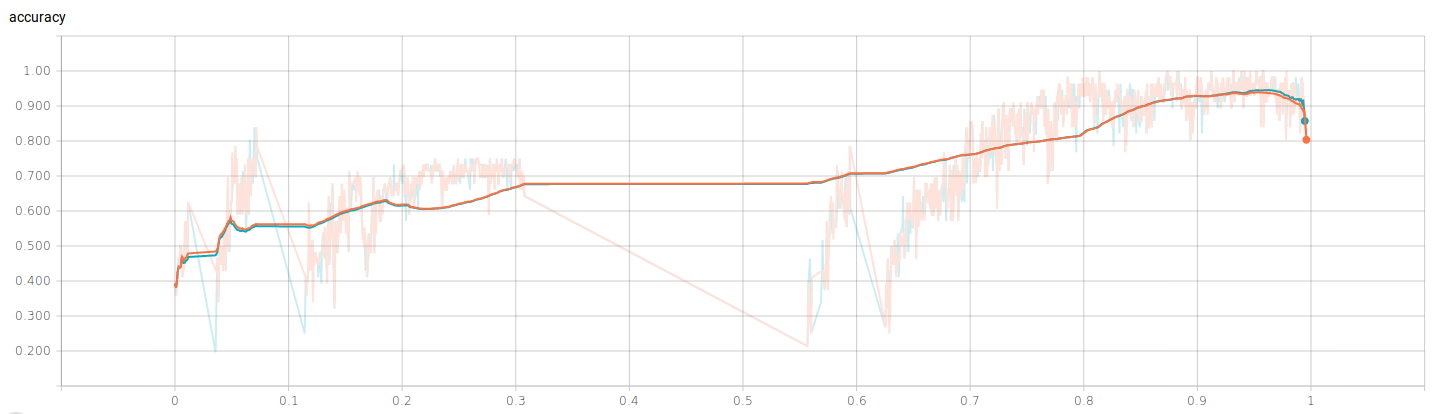

In [13]:
%matplotlib inline
from PIL import Image
img=Image.open('./accuracy.png')
img

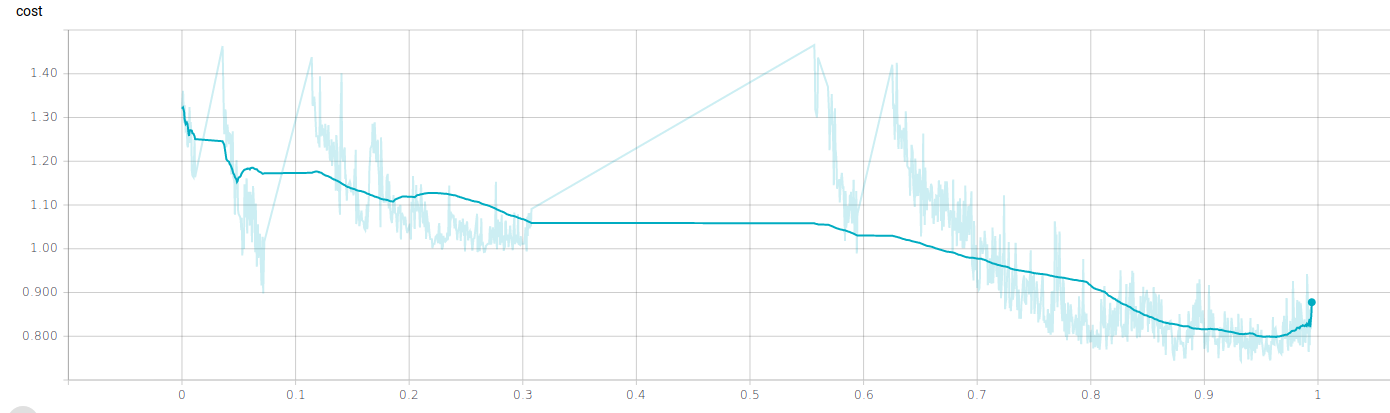

In [14]:
img=Image.open('./cost.png')
img

# Analyze the result

- the output of cost function is decreasing as steps going further. As you see the values of accuracy above and the graphs at the same time, The parameters ( weights and biases) are well optimized for this 1-dimensional dataset. It might be thought as overfitted, however, when you look at the test accuracy graph, it can be considered as well-genalized. But, still, the size of test data in each loop is composed of only 120 samples, so, if you want to further check, you should test with larger dataset.  

- On top of that, it only takes 36 epochs to converge. Therefore, the speed of convergence is quite fast.   First of all, even though resnet is fine-tuned to 1-d data and I reduce the layers compared to the original version of reset, it is still the deepest models out of the cnn models proposed so far. So, it has incredible ability to capture the general feature of data. Also, I mostly initialize the weights and bias using He initialization and put the batch normalization layers between others. 